## hop durations investigation

In [1]:
%matplotlib inline
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from datetime import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
from datetime import datetime
import numpy as np
import pandas as pd

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)
my_index = "network_weather_2-*"

my_query = {}

##  Select your link

In [2]:
# sS='UC'
# srcSiteOWDServer = "192.170.227.160"
# srcSiteThroughputServer = "192.170.227.162"

sS='CERN-PROD'
srcSiteOWDServer = "128.142.223.247"
srcSiteThroughputServer = "128.142.223.246"

# dS='IU'
# destSiteOWDServer = "149.165.225.223"
# destSiteThroughputServer = "149.165.225.224"

# dS='UIUC'
# destSiteOWDServer = "72.36.96.4"
# destSiteThroughputServer = "72.36.96.9"

# dS='ICCN'
# destSiteOWDServer = "72.36.96.4"
# destSiteThroughputServer = "72.36.126.132"

dS='pic'
destSiteOWDServer = "193.109.172.188"
destSiteThroughputServer = "193.109.172.187"

## Get the data from Elasticsearch, and store the record based on its type

In [4]:
my_query = {
    'query':{
        'filtered':{
            'query': { "match_all": {} },
            'filter':{
                'bool':{
                    'must':[
                        {'range': {'timestamp': {'gte': '2016-09-15', 'lt': '2016-09-30'}}},
                        {'term': {'_type': 'traceroute'}},
                        {'bool':
                            {'should':[
                                {'term': {'src': srcSiteOWDServer}},
                                {'term': {'src': srcSiteThroughputServer}},
                                {'term': {'src': destSiteOWDServer}},
                                {'term': {'src': destSiteThroughputServer}}
                            ]}
                        },
                        {'bool':
                            {'should':[
                                {'term': {'dest': destSiteOWDServer}},
                                {'term': {'dest': destSiteThroughputServer}},
                                {'term': {'dest': srcSiteOWDServer}},
                                {'term': {'dest': srcSiteThroughputServer}}
                            ]}
                        }
                    ]
                }
            }
        }
    }
}

scroll = list(scan(client=es, query=my_query))


In [41]:
site = {srcSiteOWDServer: sS, srcSiteThroughputServer: sS, destSiteOWDServer:dS, destSiteThroughputServer:dS}
data = {sS:pd.DataFrame(columns=['timestamp', 'hash', 'rtts','hops','ttls']),dS:pd.DataFrame(columns=['timestamp', 'hash', 'rtts','hops','ttls'])}

uniquePaths={}

data[sS][['rtts', 'hops', 'ttls']] = data[sS][['rtts', 'hops', 'ttls']].astype(list)
data[dS][['rtts', 'hops', 'ttls']] = data[dS][['rtts', 'hops', 'ttls']].astype(list)
epoch = datetime.utcfromtimestamp(0)
count = 0
for res in scroll:
    if count<1: print(res)
    count += 1
#     dt=datetime.strptime(res['_source']['timestamp'], '%Y-%m-%dT%H:%M:%S') # for data before Oct. 15 2016
    dt=datetime.utcfromtimestamp(res['_source']['timestamp']/1000.0)
    ts = (dt - epoch).total_seconds() * 1000.0
    s=site[res['_source']['src']]
    hops=[res['_source']['src']]
    hops += res['_source']['hops']
    rtts = [0]
    rtts += res['_source']['rtts']
    h=res['_source']['hash']
    if h not in uniquePaths:
        uniquePaths[h]=hops
    data[s].set_value(ts, 'timestamp', dt)
    data[s].set_value( ts, 'hash', h)
    data[s].set_value( ts, 'rtts', rtts)
    data[s].set_value( ts, 'hops', hops)
    data[s].set_value( ts, 'ttls', res['_source']['ttls'])
print(count)
print('paths:',len(uniquePaths))
for p in uniquePaths:
    print(uniquePaths[p])

{'_type': 'traceroute', '_source': {'dest': '193.109.172.187', 'srcVO': 'ATLAS', 'destSite': 'pic', 'destProduction': True, 'srcSite': 'CERN-PROD', 'rtts': [0.33, 0.26, 0.884, 97.447, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'srcProduction': True, 'destVO': 'ATLAS', 'src': '128.142.223.246', 'hash': -9137248274871885722, 'ttls': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'timestamp': 1473897639000, 'hops': ['10.32.134.1', '172.24.32.45', '172.24.32.38', '192.16.166.58', None, None, None, None, None, None, None, None, None, None], 'MA': '128.142.223.246'}, '_id': 'AVcrfTsFsPCefqD7dBR9', '_score': 0.0, '_index': 'network_weather_2-2016.9.15'}
1099
paths: 28
['128.142.223.246', '10.32.134.1', '172.24.32.109', '172.24.32.38', '192.16.166.58', None, None, None, None, None, None, None, None, None, None]
['128.142.223.246', '10.32.134.1', '172.24.32.77', '172.24.32.102', '192.16.166.58', None, None, None, None, None, None, None, None, None, None]
['128.142.223.246', '10.32.134

In [6]:
data[sS].sort_index(inplace=True) 
#data[sS].describe(include=['hash'])

data[dS].sort_index(inplace=True) 
#data[dS].describe()

In [7]:
data[sS]

,timestamp,hash,rtts,hops,ttls
1.473898e+12,2016-09-15 00:00:39,-9137248274871885722,"[0, 0.33, 0.26, 0.884, 97.447, 0.0, 0.0, 0.0, ...","[128.142.223.246, 10.32.134.1, 172.24.32.45, 1...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]"
1.473898e+12,2016-09-15 00:02:19,8432925594183403436,"[0, 0.275, 0.184, 0.23, 113.68, 0.0, 0.0, 0.0,...","[128.142.223.246, 10.32.134.1, 172.24.32.109, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]"
1.473901e+12,2016-09-15 00:59:56,2032318259770747939,"[0, 11.364, 0.201, 0.399, 32.678, 0.0, 0.0, 0....","[128.142.223.246, 10.32.134.1, 172.24.32.109, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]"
1.473902e+12,2016-09-15 01:06:32,-4111486330865547962,"[0, 0.267, 0.226, 0.272, 33.273, 0.0, 0.0, 0.0...","[128.142.223.246, 10.32.134.1, 172.24.32.77, 1...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]"
1.473905e+12,2016-09-15 02:01:46,1223298077392329657,"[0, 0.248, 0.312, 0.478, 32.159, 0.0, 0.0, 0.0...","[128.142.223.246, 10.32.134.1, 172.24.32.45, 1...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]"
1.473906e+12,2016-09-15 02:12:14,1223298077392329657,"[0, 4.952, 0.234, 0.28, 31.083, 0.0, 0.0, 0.0,...","[128.142.223.246, 10.32.134.1, 172.24.32.45, 1...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]"
1.473908e+12,2016-09-15 02:57:42,8432925594183403436,"[0, 0.359, 0.231, 0.342, 35.295, 0.0, 0.0, 0.0...","[128.142.223.246, 10.32.134.1, 172.24.32.109, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]"
1.473909e+12,2016-09-15 03:08:30,8432925594183403436,"[0, 0.335, 0.191, 0.185, 51.921, 0.0, 0.0, 0.0...","[128.142.223.246, 10.32.134.1, 172.24.32.109, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]"
1.473912e+12,2016-09-15 03:59:35,8432925594183403436,"[0, 3.659, 0.213, 0.273, 32.475, 0.0, 0.0, 0.0...","[128.142.223.246, 10.32.134.1, 172.24.32.109, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]"
1.473913e+12,2016-09-15 04:09:19,2887248898823817920,"[0, 0.298, 0.205, 0.441, 147.815, 0.0, 0.0, 0....","[128.142.223.246, 10.32.134.1, 172.24.32.109, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]"


### Extract values

In [33]:
F = data[sS]
B = data[dS]

hopTimes={}

for rec,fi in enumerate(F.hops):
    for i in range(1,len(fi)):
        if not fi[i-1] or not fi[i]: continue
        hopName=fi[i-1]+'->'+fi[i]
        #print(rec, hopName)
        rts = F.rtts.iloc[[rec]].tolist()[0]
#        print (i, rts)
        if hopName not in hopTimes: hopTimes[hopName]=[]
        hopTimes[hopName].append( rts[i] - rts[i-1] )
#for h in hopTimes:
#    print(h, hopTimes[h])
print('hops seen:', len(hopTimes))
print(hopTimes.keys())

hops seen: 25
dict_keys(['172.24.32.77->172.24.32.102', '62.40.126.198->130.206.206.154', '172.24.32.70->192.16.166.58', '10.32.134.1->172.24.32.109', '172.24.32.109->172.24.32.106', '172.24.32.74->62.40.126.217', '172.24.32.45->172.24.32.102', '62.40.126.217->62.40.98.152', '128.142.223.246->10.32.134.1', '62.40.126.197->62.40.126.198', '172.24.32.77->172.24.32.38', '172.24.32.45->172.24.32.70', '172.24.32.38->192.16.166.58', '62.40.98.152->62.40.126.197', '172.24.32.45->172.24.32.74', '172.24.32.109->172.24.32.70', '172.24.32.77->172.24.32.70', '172.24.32.106->62.40.126.217', '172.24.32.45->172.24.32.38', '10.32.134.1->172.24.32.77', '172.24.32.77->172.24.32.106', '172.24.32.109->172.24.32.102', '172.24.32.109->172.24.32.38', '10.32.134.1->172.24.32.45', '172.24.32.102->192.16.166.58'])


#### reorganize for plotting

In [38]:
x=hopTimes['172.24.32.77->172.24.32.102']
x1=hopTimes['172.24.32.102->192.16.166.58']

/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


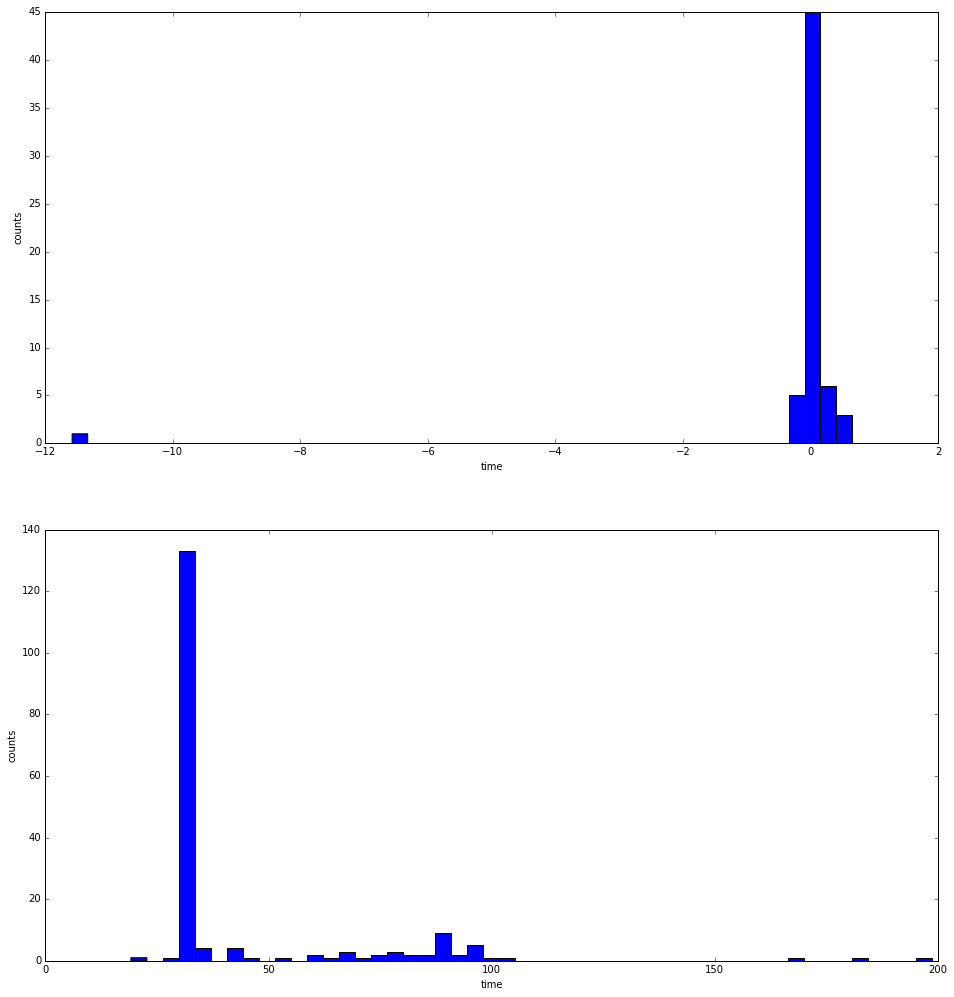

In [39]:
plt.figure(figsize=[16, 17])
gs = gridspec.GridSpec(2, 1)

ax0 = plt.subplot(gs[0])
ax0.hist(x,50,histtype='bar', stacked=True)
#ax0.plot(Bthr.timestamp.tolist(), Bthr.throughput.tolist(),  label=dS+'->'+sS)
ax0.set_xlabel('time')
ax0.set_ylabel('counts')#,rotation='horizontal')
#ax0.xlim(xmin=0)
ax0.legend()

ax0 = plt.subplot(gs[1])
ax0.hist(x1,50,histtype='bar', stacked=True)
#ax0.plot(Bthr.timestamp.tolist(), Bthr.throughput.tolist(),  label=dS+'->'+sS)
ax0.set_xlabel('time')
ax0.set_ylabel('counts')#,rotation='horizontal')
#ax0.xlim(xmin=0)
ax0.legend()

# ax4 = plt.subplot(gs[2])
# ax4.plot(Fd.timestamp.tolist(), Fd.delay_mean.tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
# ax4.plot(Bd.timestamp.tolist(), Bd.delay_mean.tolist(), ls='', marker='.', c='b', label=dS+'->'+sS)
# ax4.plot(Jd.timestamp.tolist(), Jd.dmean.tolist(), ls='-', marker='.', c='g', label='mean delay')
# ax4.set_xlabel('time')
# ax4.set_ylabel('one way delay [ms]')
# ax4.legend()

# ax6 = plt.subplot(gs[3])
# ax6.plot(Fh.timestamp.tolist(), Fids, ls='', marker='.', c='r', label=sS+'->'+dS)
# ax6.plot(Bh.timestamp.tolist(), Bids, ls='', marker='.', c='b', label=dS+'->'+sS)
# ax6.set_xlabel('time')
# ax6.set_ylabel('path index')
# ax6.legend()

plt.savefig('Plots/HopDurations_' + sS +'_'+ dS + '.png',dpi=200)
plt.show()